# I'm Picking Up Crop Rotations

In this assignment you will examine crop rotation in the state of Illinois. One of the most common patterns of crop rotation is corn being rotated with soybeans. You have two years of Cropland Data Layer (CDL), 2016 and 2017, from which to examine how common the phenomenon is in Illinois. 

__NOTE__: you will need to make use of the CDL documentation to answer many of these questions.


1. Clip the 2016 and 2017 CDL rasters to the state of Illinois. Plot the clipped and unclipped rasters side by side for each year.(2 points)
2. Summarize the top 10 land uses in Illinois in each year in a table. (2 points)
3. Create two rasters for each year: (2 points)
    - 1 if pixel is corn, 0 otherwise
    - 1 if pixel is soybeans, 0 otherwise
    
    And then plot them (4 rasters total).
4. Describe the degree of crop rotation (corn and soybeans only) between 2016 and 2017 by using a table or a graph (2 points).
5. Create a raster using the CDL layers where each pixel is labeled: (2 points)
    - 1 = corn stayed corn
    - 2 = soybeans stayed soybeans
    - 3 = corn changed to soybeans
    - 4 = soybeans changed to corn
    - 0 = any other case.
    
6. Visualize the raster on top of the Illinois shapefile. (__BONUS GRAPH__: To submit your graph for two extra credit points, please put a markdown cell above your graph code that says "__My Submission__") (3 points)
7. Suppose a client has the following question: (4 points)
    
    __"What are the crop yield advantages of crop rotation as compared to monocropping in Illinois?"__
   
   Describe how you might answer this question using the CDL layer, specifically:
       - What data sources you would need in addition to the raster you just created.
       - How you would manipulate the data.
       - What statistics you would calculate or model you would run on this data.
       - How you might present your findings.
8. What factors would make it difficult to accurately answer the question? List three and explain why they might make answering the question difficult. (3 points)

In [3]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d

In [4]:
states = gpd.read_file('us_states.json')
IL = states[states.STATE == "17"]
d16 = rasterio.open('/Users/isaacwerries/Desktop/test/CDL_2016_clip (1).tif')
d17 = rasterio.open('/Users/isaacwerries/Desktop/test/CDL_2017_clip (1).tif')

<AxesSubplot:>

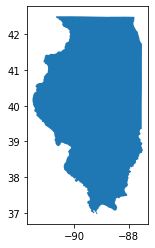

In [5]:
IL.plot()

In [6]:
d16.crs == IL.crs

False

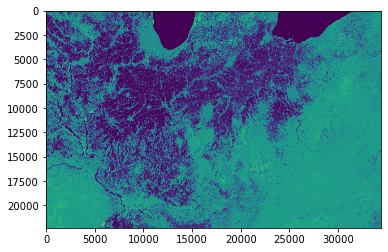

In [7]:
plt.imshow(d16.read(1))

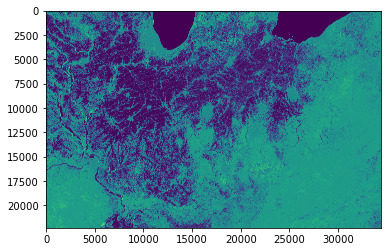

In [8]:
plt.imshow(d17.read(1))

In [9]:
IL16 = IL.to_crs(d16.crs)
IL17 = IL.to_crs(d17.crs)

In [10]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(IL16)
IL_coords2 = getFeatures(IL17)

In [11]:
def clip_raster(raster,vector,filename):
    img_out, img_transform = mask(raster,getFeatures(vector))
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [12]:
IL_raster = clip_raster(d16,IL16,"IL16_CDL")
IL_raster2 = clip_raster(d17,IL17,"IL17_CDL")

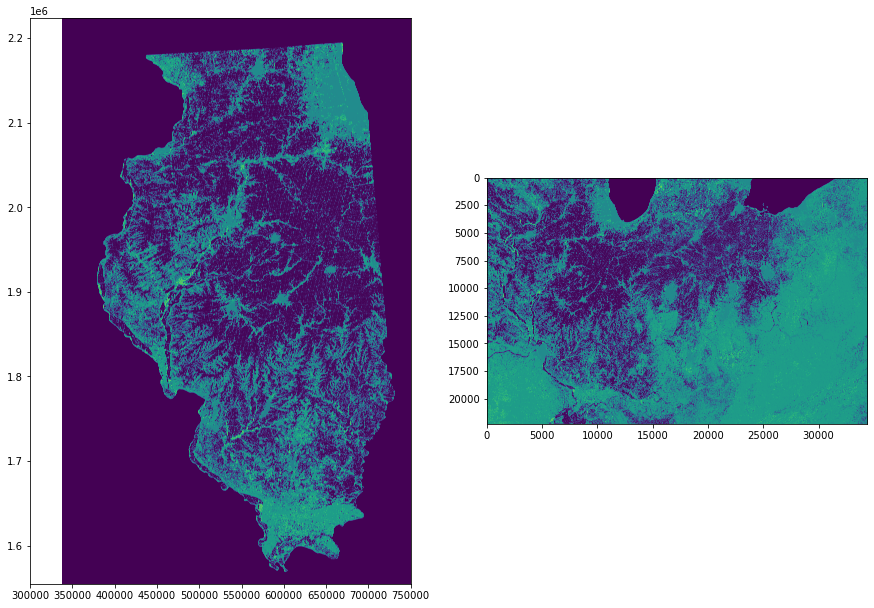

In [105]:
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(15, 15),nrows=1, ncols=2)
rasterio.plot.show(IL_raster, ax=ax[0])
ax[0].set_xlim(300000,750000)
plt.imshow(d16.read(1))

In [ ]:
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(15, 15),nrows=1, ncols=2)
rasterio.plot.show(IL_raster2, ax=ax[0])
ax[0].set_xlim(300000,750000)
plt.imshow(d17.read(1))

In [15]:
d16_array = IL_raster.read(1)
pixels16 = pd.Series(d16_array.flatten())
pixels16 = pixels16[pixels16!=0]
d17_array = IL_raster2.read(1)
pixels17 = pd.Series(d17_array.flatten())
pixels17 = pixels17[pixels17!=0]

In [16]:
pix_counts16 = pixels16.value_counts()
pix_counts17 = pixels17.value_counts()
pix_counts16.head(10)

1      51601196
5      43058354
141    25593818
176    14392021
122     7659122
121     7342593
111     2902471
123     2670760
190     1849448
26      1456404
dtype: int64

In [17]:
pix_counts17.head(10)

1      50384325
5      44901528
141    25540784
176    14179426
122     7641962
121     7299778
111     2901269
123     2686450
190     1864898
26      1293584
dtype: int64

In [18]:
with open("/Users/isaacwerries/Desktop/test/IL_LandUse.json") as f:
    LU = json.load(f)

In [19]:
pixel_ixs16 = pd.Series(pix_counts16.index).astype(str)
ixs16 = pixel_ixs16.replace(LU).head(10)
df16 = pd.DataFrame(ixs16)
df16

,0
0,Corn
1,Soybeans
2,Deciduous Forest
3,Grassland/Pasture
4,Developed/Low Intensity
5,Developed/Open Space
6,Open Water
7,Developed/Med Intensity
8,Woody Wetlands
9,Dbl Crop WinWht/Soybeans


In [20]:
pixel_ixs17 = pd.Series(pix_counts17.index).astype(str)
ixs17 = pixel_ixs17.replace(LU).head(10)
df17 = pd.DataFrame(ixs17)
frames = [df16,df17]
df = pd.concat(frames,axis=1)

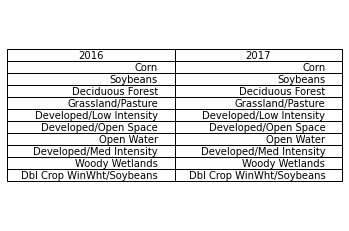

In [21]:
fig, ax =plt.subplots(1,1)
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=df.values, colLabels=('2016','2017'), loc='center')
plt.show()

In [85]:
corn_mask16 = IL_raster.read(1) == 1
bean_mask16 = IL_raster.read(1) == 5
corn_mask17 = IL_raster2.read(1) == 1
bean_mask17 = IL_raster2.read(1) == 5

In [86]:
def raster_cfo(raster,filename,mask):
    x = raster.read(1)
    img_out = np.zeros(x.shape) # 0 for other
    
    img_out[mask] = 1 # 1 for crops
    
    img_out = img_out[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = raster.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [87]:
corn16 = raster_cfo(IL_raster,'corn16',corn_mask16)
bean16 = raster_cfo(IL_raster,'bean16',bean_mask16)
corn17 = raster_cfo(IL_raster2,'corn17',corn_mask17)
bean17 = raster_cfo(IL_raster2,'bean17',bean_mask17)

(300000.0, 750000.0)

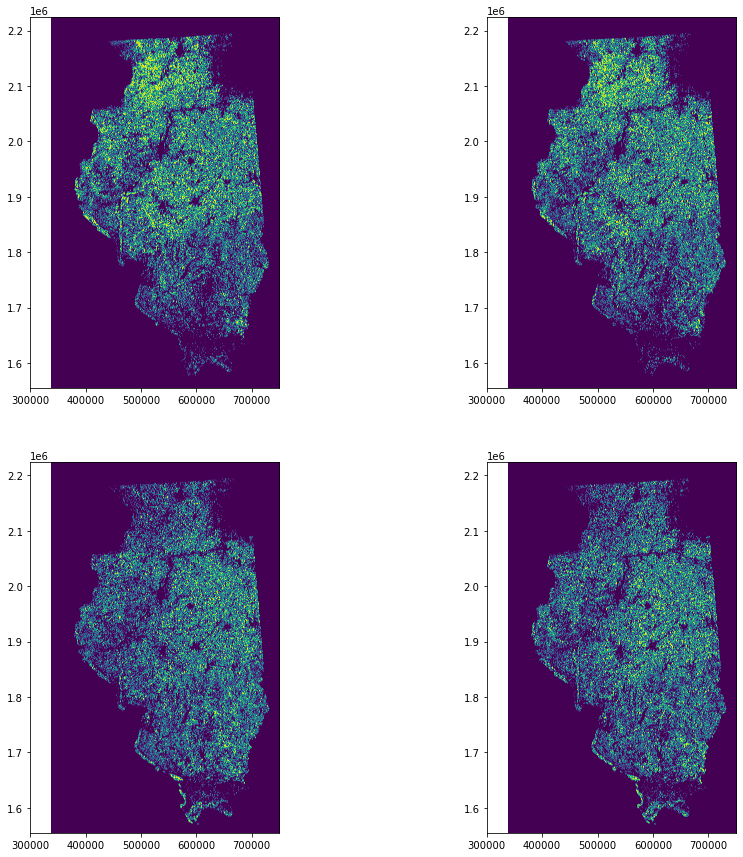

In [104]:
fig, ax = plt.subplots(figsize=(15, 15),nrows=2, ncols=2)
rasterio.plot.show(corn16, ax=ax[0,0])
rasterio.plot.show(bean16, ax=ax[1,0])
rasterio.plot.show(corn17, ax=ax[0,1])
rasterio.plot.show(bean17, ax=ax[1,1])
ax[0,0].set_xlim(300000,750000)
ax[1,0].set_xlim(300000,750000)
ax[0,1].set_xlim(300000,750000)
ax[1,1].set_xlim(300000,750000)

In [92]:
def visualize_rotate(y1,y2,filename):
    a1 = y1.read(1)
    a2 = y2.read(1)
    
    C_to_C = (a1==1)&(a2==1)
    C_to_B = (a1==1)&(a2==5)
    B_to_C = (a1==5)&(a2==1)
    B_to_B = (a1==5)&(a2==5)
    
    a = np.zeros(a1.shape)
    
    a[C_to_C] = 1
    a[C_to_B] = 2
    a[B_to_C] = 3
    a[B_to_B] = 4
    
    img_out = a[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = y1.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = y1.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [93]:
rotate_labels = {0:"Background",
                 1:"Corn on Corn",
                 2:"Corn to Beans",
                 3:"Beans to Corn",
                 4:"Beans on Beans"}

In [94]:
rot16_17 = visualize_rotate(IL_raster,IL_raster2,'rot16_17')

In [98]:
rot16_17

<open DatasetReader name='./rot16_17.tif' mode='r'>

(300000.0, 750000.0)

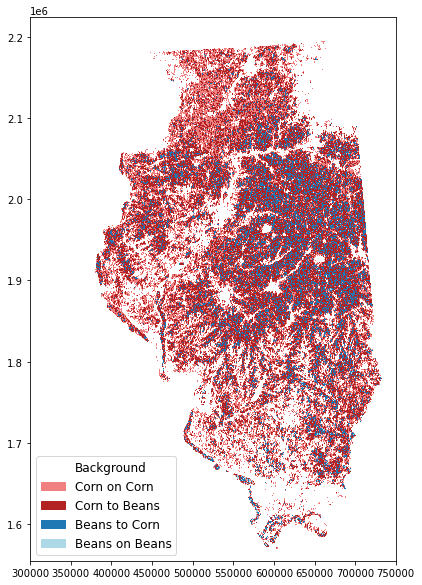

In [103]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = matplotlib.colors.ListedColormap(["white","lightcoral","firebrick", 'C0','lightblue'])
patches =[mpatches.Patch(color=cmap(i),label=rotate_labels[i]) for i in rotate_labels.keys()]
rasterio.plot.show(rot16_17 ,cmap=cmap,ax=ax)
plt.legend(handles=patches,fontsize=12,loc='lower left')
ax.set_xlim(300000,750000)